# Convert PicoQuant ns-ALEX files to Photon-HDF5

<p class="lead">This <a href="https://jupyter.org/">Jupyter notebook</a>
will guide you through the conversion of a ns-ALEX data file from PicoQuant formats <b>(PTU, HT3, PT3)</b>
to <a href="http://photon-hdf5.org">Photon-HDF5</a> format. For more info on how to edit
a jupyter notebook refer to <a href="http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb#Overview-of-the-Notebook-UI">this example</a>.</p>

*Please send feedback and report any problem to the 
[Photon-HDF5 google group](https://groups.google.com/forum/#!forum/photon-hdf5).*

# 1. How to run it?

The notebook is composed by "text cells", such as this paragraph, and "code cells"
containing the code to be executed (and identified by an `In [ ]` prompt). 
To execute a code cell, select it and press **SHIFT+ENTER**. 
To modify an cell, click on it to enter "edit mode" (indicated by a green frame), 
then type.

You can run this notebook directly online (for demo purposes), or you can 
run it on your on desktop. For a local installation please refer to:

- [Jupyter Notebook Quick-Start Guide](http://jupyter-notebook-beginner-guide.readthedocs.org) 

<br>
<div class="alert alert-info">
Please run each each code cell using <b>SHIFT+ENTER</b>.
</div>

# 2. Prepare the data file

## 2.1 Import modules

First we need to import ``phconvert`` as well as a few other standard python modules into the python environment

In [1]:
import os
import numpy as np

import phconvert as phc
print('phconvert version: ' + phc.__version__)

phconvert version: 0.9.post140+ge2224ab.d20240805


## 2.2 Upload the data file

<br>
<div class="alert alert-info">
<b>Note:</b> if you are running the notebook locally skip to section [<b>2.3</b>].
</div>

Before starting, you have to upload a data file to be converted to Photon-HDF5.
You can use one of our example data files available
[on figshare](http://dx.doi.org/10.6084/m9.figshare.1455963). 

To upload a file (up to 35 MB) switch to the "Home" tab in your browser, 
click the **Upload** button and select the data file
and wait until the upload completes.
To upload files larger than 35 MB (like some of our example files) please use the 
[Upload notebook](Upload data files.ipynb) instead.

Once the file is uploaded, come back here and follow the instructions below.

## 2.3 Select the file

Specify the input data file in the following cell:

In [2]:
filename = 'data/dsdna_d7d17_50_50_1.spc'

The next cell will check if the `filename` location is correct:

In [3]:
if os.path.isfile(filename):
    print("File found, you can proceed")
else:
    if os.path.exists(filename):
        raise FileNotFoundError(f"'{filename}' is not a file")
    else:
        raise FileNotFoundError(f"'{filename}' does not exist")

File found, you can proceed


If there is an error, adjust the `filename` cell to the correct location

## 3.1 Load the file

First we load the `phconvert` module and some standard python modules

Now we can load the data into the notebook

In [4]:
data, metadata = phc.loader.loadfile_bh(filename)

TCSPC parameters retrived from the .SET file.


#### 3.2.1 Metadata

Now we fill out some metadata so the nature of the experiment can be known.

In [5]:
# Sample fields
author = 'John Doe'
author_affiliation = 'Research Institution'
description = 'A demonstrative measurement.'
sample_name = 'A demonstrative fluorescently labeled construct'
dye_names = 'dyeA, dyeB'
buffer_name = 'A standard buffer'
measurement_type = 'generic' # can be 'smFRET', 'smFRET-nsALEX', smFRET-usALEX' etc.

sample = dict(
    sample_name=sample_name,
    dye_names=dye_names,
    buffer_name=buffer_name,
    num_dyes = len(dye_names.split(',')))

#### 3.2.2 Emission parameters

As the acquisition software does not know about all the
filters and various distances between detectors etc.,
it is necessary to add these experimental configuration settings
in the jupyter noteboo.

In [6]:
# Setup parameters
excitation_wavelengths = np.array([488e-9, 632e-9])
excitation_cw = np.array([False, False])
excitation_alternated = np.array([False, False])
detection_wavelengths = np.array([580e-9, 690e-9])

Populate the data dictionary with the various metadata fields in their correct names/positions

In [7]:
data['description'] = description
data['sample'] = sample
data['identity']['author'] = author
data['identity']['author_affiliation'] = author_affiliation
phc.helperfuncs.fill_measurement_type(data, measurement_type)

The detector indexes used in the file are recorded in the
`/photon_data/measurement_specs/detectors_specs/spectral_polarization_split_chN`
key in the data dictionary.

This key must be removed as it is not a valid field in photon-HDF5.
This field is exported by the `loader.loadfile_ptu` function because
the detectors must be assigned to several field, namely:

- `spectral_ch1`, `spectral_ch2` ... etc
- `polarization_ch1`, `polarization_ch2` ... etc
- `split_ch1`, `split_ch2` ... etc

if for any of these categories has only one channel/photons are not sorted in the
given way by the setup, it can be ommitted.

Since `phconvert` has no way of knowing how to assign detectors to these fields,
it stores all of them in a 'hint' field, so the user can at least know what the
detectors are, and can assign them appropriately.

The cell bellow shows all the detector indexes in a list:

In [8]:
detectors_specs = data['photon_data']['measurement_specs']['detectors_specs']
setup = data['setup']
detectors_ids = detectors_specs.pop('spectral_polarization_split_chN')
print(detectors_ids)

[0 4 6]


Now assign the detector ids to the correct channels.

The code below will be modified according to the actual detectors used.

In [9]:
# Adjust according to how each detector is assigned to spectral/polarization/split channels
detectors_specs['spectral_ch1'] = detectors_ids[2:3]
detectors_specs['spectral_ch2'] = detectors_ids[1:2]
# detectors_specs['polarization_ch1'] = detectors_ids[::2]
# detectors_specs['polarization_ch2'] = detectors_ids[1::2]
# detectors_specs['split_ch1'] = detectors_ids[::2]
# detectors_specs['split_ch2'] = detectors_ids[1::2]

If your TCSPC device adds sync photons, space-time markers, or any other sort of marker,
these must be assigned to `markers1` `markers2` ... etc. (only a single field is needed)

The `loader.loadfile_ptu` loads these into `markersN` for the same reason it uses
`spectral_polarization_split_chN`. So assign appropriately

If there are no markers, the `markersN` field will not be present in the output dictionary,
and the `markers1` field is not needed.

In [10]:
non_photon_id = detectors_specs.get('non_photon_id1', list())
print(non_photon_id)

[]


The code bellow is a "dummy" code, basically if markers are present, it assigns them all to `markers1`

In [11]:
for i, nph in enumerate(non_photon_id):
    detectors_specs[f'non_photon_id{i}'] = np.array([nph,])

### 3.2.3 Emission parameters

When multiple excitations are present, the period for each excitation should be specified.

`phconvert` supplies a useful function for choosing the ideal range(s) for each period,
and for visualizing the appearance of the decays, this is `plotter.alternation_hist`

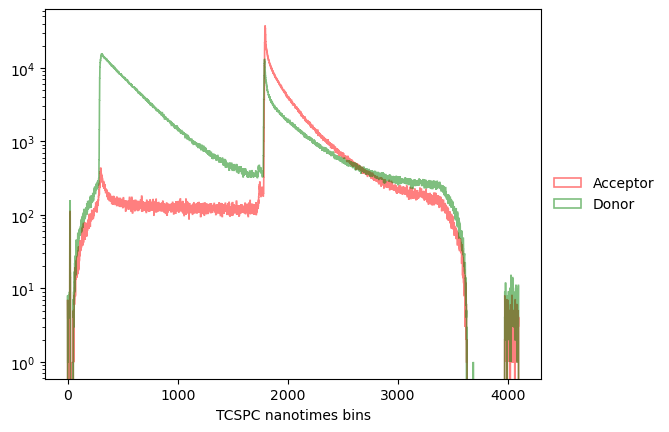

In [12]:
phc.plotter.alternation_hist(data, group_dets=True)

From this plot, iterate with the cell below to find the best windows:

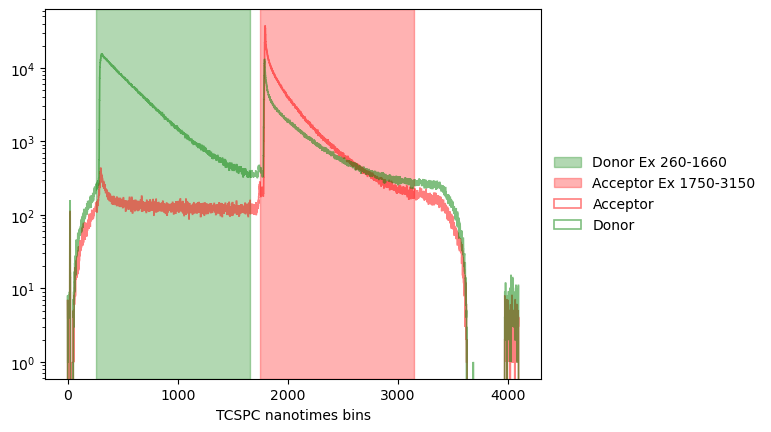

In [13]:
alex_excitation_donor = (260, 1660)
alex_excitation_acceptor = (1750, 3150)
phc.helperfuncs.fill_alex_periods(data, alex_excitation_donor, alex_excitation_acceptor)
phc.plotter.alternation_hist(data, group_dets=True)

Once those field look well aligned, there may be an offset between the decays
of different detectors due to speed of light delays.
Therefore, the optional field `/setup/detectors/tcspc_offsets` allows each
detector id to be given its own integer offset, in `tcspc_unit` units.

Again, iterate with the cell below to allign the decays so that they are alligned
within the excitation windows idealy:

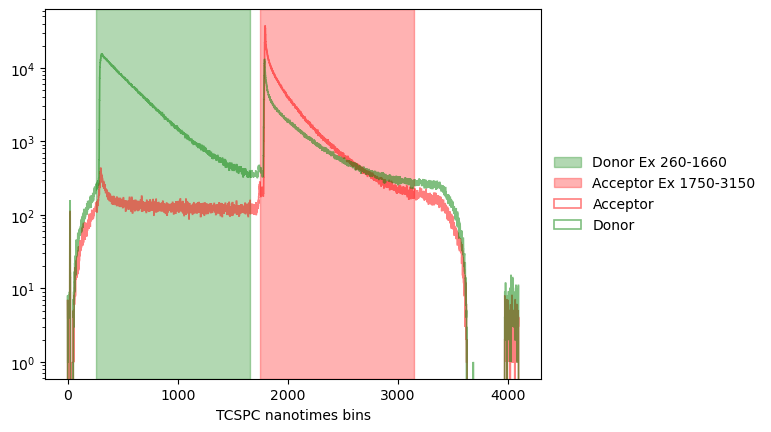

In [14]:
setup['detectors']['tcspc_offsets'] = np.array([0, 0, 0])
phc.plotter.alternation_hist(data, group_dets=True)

Some final fields to fill out:

In [15]:
phc.helperfuncs.fill_setup(data)

setup['excitation_wavelengths'] = excitation_wavelengths
setup['excitation_cw'] = excitation_cw
setup['excitation_alternated'] = excitation_alternated
setup['detection_wavelengths'] = detection_wavelengths
setup['detectors']['label'] = np.array(['sync', 'donor','acceptor'])

The `report_nones` function will print out any fields you still need to fill out.
If you have filled everything out, the cell bellow should have no output

In [16]:
phc.helperfuncs.report_nones(data)

We store the metadata in the `user/picoquant` group so that no data is lost.
This data will not be processed by standard photon-HDF5 readers,
but may be helpful for human readers debugging or othewise investigating the file.

## 4. Save the file

In [17]:
data['setup']

{'num_pixels': 3,
 'num_spots': 1,
 'num_spectral_ch': 2,
 'num_polarization_ch': 1,
 'num_split_ch': 1,
 'modulated_excitation': True,
 'lifetime': True,
 'excitation_wavelengths': array([4.88e-07, 6.32e-07]),
 'excitation_cw': array([False, False]),
 'detection_wavelengths': array([5.8e-07, 6.9e-07]),
 'excitation_alternated': array([False, False]),
 'detectors': {'id': array([0, 4, 6], dtype=uint8),
  'counts': array([      1, 3345380, 6371466]),
  'label': array(['sync', 'donor', 'acceptor'], dtype='<U8'),
  'tcspc_offsets': array([0, 0, 0])},
 'laser_repetition_rates': array([6.0122041e-08, 6.0122041e-08])}

In [18]:
phc.hdf5.save_photon_hdf5(data, h5_fname='testout.hdf5', overwrite=True)

Saving: testout.hdf5


The conversion is complete, the remainder of the notebook is just for verifying that the file was saved correctly.

## 5. Check file

Now load the file to ch

In [19]:
h5file = phc.hdf5.load_photon_hdf5('testout.hdf5')
d = phc.hdf5.dict_from_group(h5file.root)
h5file.close()

In [20]:
d['photon_data']

{'detectors': array([6, 6, 4, ..., 6, 6, 6], dtype=uint8),
 'measurement_specs': {'alex_excitation_period1': [260, 1660],
  'alex_excitation_period2': [1750, 3150],
  'detectors_specs': {'markers1': array([0], dtype=uint8),
   'spectral_ch1': array([6], dtype=uint8),
   'spectral_ch2': array([4], dtype=uint8)},
  'laser_repetition_rate': 6.0122041e-08,
  'measurement_type': 'generic'},
 'nanotimes': array([ 372,  579, 1926, ..., 2553, 1182,  316], dtype=uint16),
 'nanotimes_specs': {'tcspc_num_bins': 4096,
  'tcspc_range': 6.0122042368e-08,
  'tcspc_unit': 1.4678233e-11},
 'timestamps': array([       3535,        4553,        9237, ..., 37727795162,
        37727808379, 37727833031]),
 'timestamps_specs': {'timestamps_unit': array(5.e-08)}}

In [21]:
d['setup']

{'detection_wavelengths': array([5.8e-07, 6.9e-07]),
 'detectors': {'counts': array([      1, 3345380, 6371466]),
  'id': array([0, 4, 6], dtype=uint8),
  'id_hardware': array([0, 4, 6], dtype=uint8),
  'label': array([b'sync', b'donor', b'acceptor'], dtype='|S8'),
  'tcspc_offsets': array([0, 0, 0])},
 'excitation_alternated': array([False, False]),
 'excitation_cw': array([False, False]),
 'excitation_wavelengths': array([4.88e-07, 6.32e-07]),
 'laser_repetition_rates': array([6.0122041e-08, 6.0122041e-08]),
 'lifetime': 1,
 'modulated_excitation': 1,
 'num_pixels': 3,
 'num_polarization_ch': 1,
 'num_spectral_ch': array(2),
 'num_split_ch': 1,
 'num_spots': 1}

In [22]:
data['photon_data']['nanotimes'][data['photon_data']['detectors']==0]

array([2009], dtype=uint16)